# Metropolis random walk: extensive testing on toy problems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
from utils import run_replicates, ecdf_norm_plotter

import pints
import pints.toy
import pints.plot
from pints.functionaltests.metropolis import (test_metropolis_on_banana,
                                               test_metropolis_on_two_dim_gaussian,
                                               test_metropolis_on_correlated_gaussian)

# Two dimensional Gaussian

In [2]:
test = run_replicates(np.geomspace(2000, 20000, 8), 10, test_metropolis_on_two_dim_gaussian)

/home/chonlei/work/dev/pints-method-merge-tests/venv/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


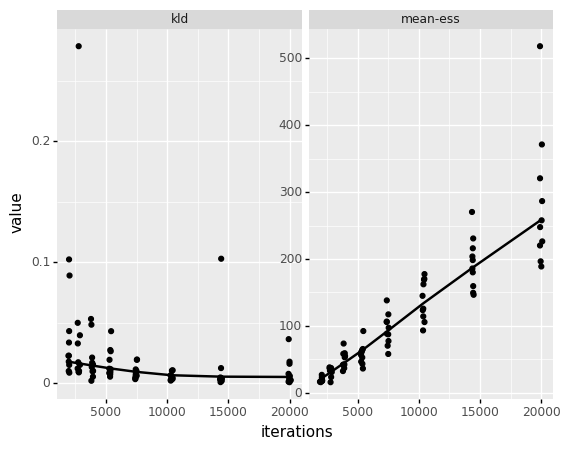

<ggplot: (8740539992649)>

In [3]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The ESS and KLD both trend in the correct directions.

Show example run results.

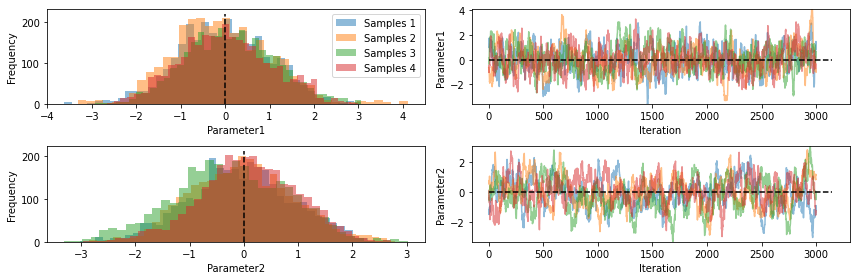

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.02    1.06    -1.95   -0.72  -0.01  0.73   2.06     1.00    324.98  167.35
param 2  -0.06   0.96    -1.99   -0.70  -0.07  0.60   1.77     1.01    213.28  109.83


In [4]:
n_chains = 4
n_iterations = 4000
n_warmup = 1000
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MetropolisRandomWalkMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

The parameters are close to their true means. How do they compare to MCMC eCDFs compare with the theoretical? Look pretty good.

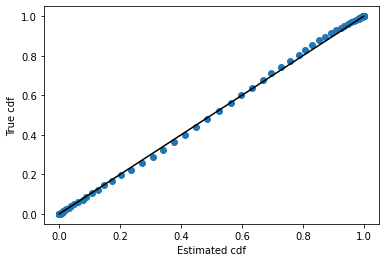

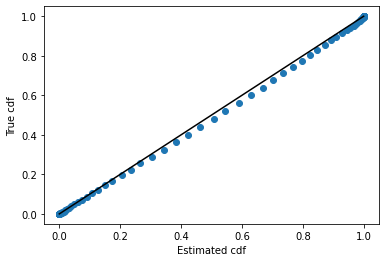

[None, None]

In [5]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

# Correlated Gaussian

In [6]:
test = run_replicates(np.geomspace(5000, 20000, 8), 10, test_metropolis_on_correlated_gaussian)

/home/chonlei/work/dev/pints-method-merge-tests/venv/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


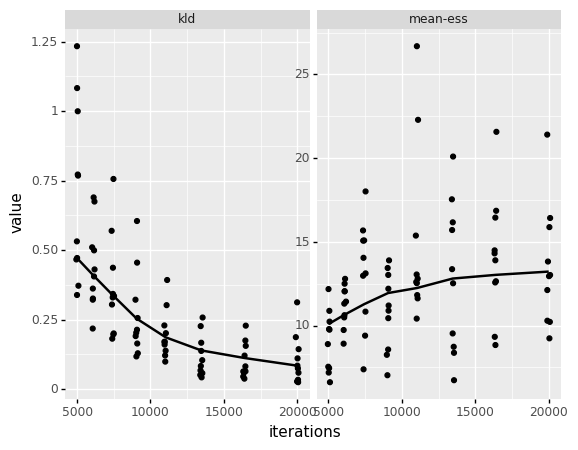

<ggplot: (8740537927617)>

In [7]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

Both the ESS and KLD do not behave as well as the 2D Guassian case. It's likely that this is due to the problem being too hard for Metropolis random walk and hence the 'improved version' such as those adaptive methods.

Example run of results.

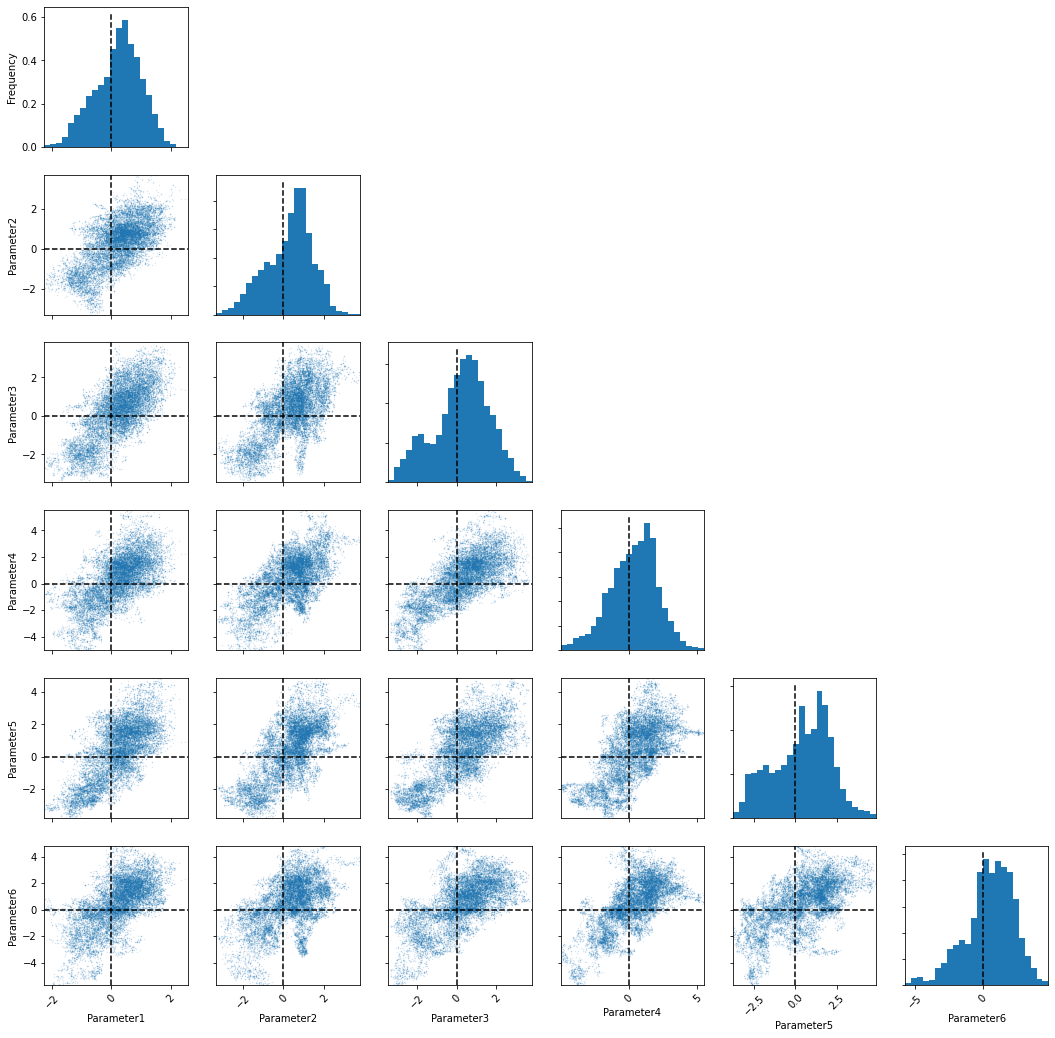

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
param 1  0.22    0.78    -1.38   -0.30  0.30   0.77   1.57     1.51    65.74  15.29
param 2  0.29    1.14    -2.14   -0.47  0.49   1.05   2.16     1.56    30.63  7.13
param 3  0.26    1.39    -2.63   -0.55  0.42   1.22   2.72     1.53    58.10  13.51
param 4  0.36    1.74    -3.54   -0.77  0.51   1.58   3.50     1.54    53.83  12.52
param 5  0.38    1.73    -2.97   -0.88  0.57   1.67   3.39     1.84    35.17  8.18
param 6  0.49    1.78    -3.46   -0.44  0.68   1.76   3.49     1.47    35.45  8.25


In [8]:
n_chains = 4
n_iterations = 8000
n_warmup = 4000

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MetropolisRandomWalkMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

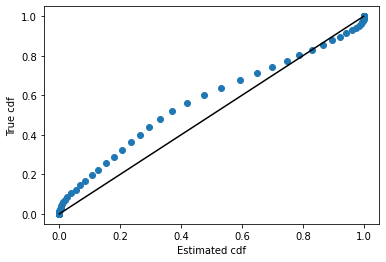

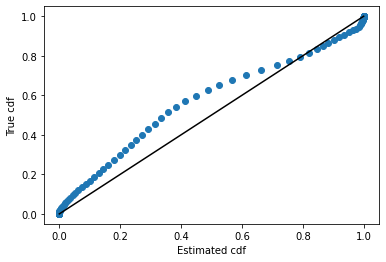

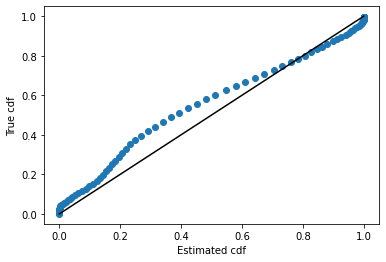

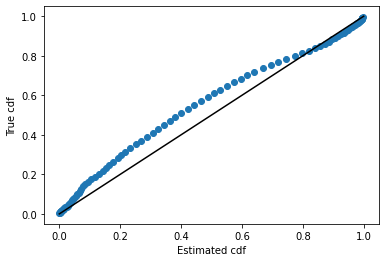

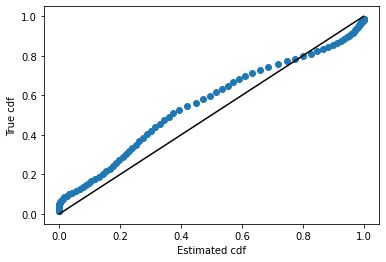

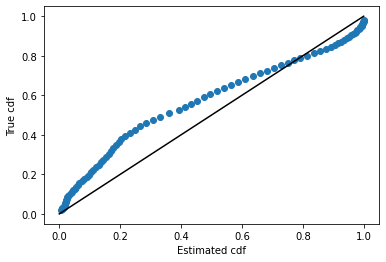

[None, None, None, None, None, None]

In [9]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

# Banana

In [10]:
test = run_replicates(np.geomspace(2000, 10000, 8), 10, test_metropolis_on_banana)

/home/chonlei/work/dev/pints-method-merge-tests/venv/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


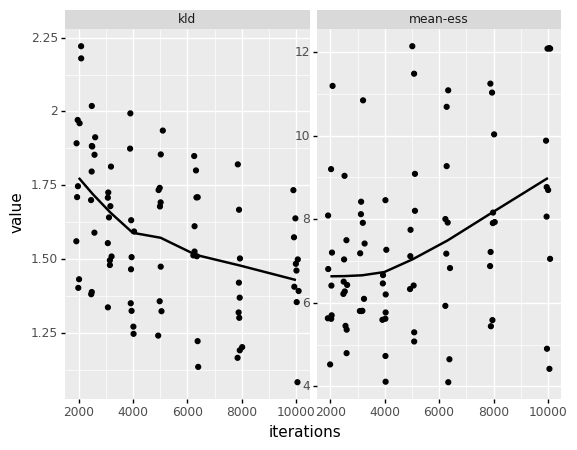

<ggplot: (8740531034067)>

In [11]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

Again, both the ESS and KLD do not behave as well. The banana is an even-harder problem than the correlated Gaussian problem. It's likely that this is due to the problem being too hard for Metropolis random walk, rather than there being an issue with the method itself.

Example run of results, showing that Metropolis random walk wasn't able to fully explore the banana PDF.

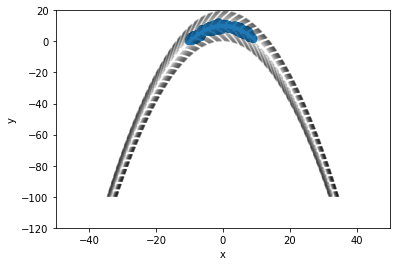

In [13]:
n_chains = 4
n_iterations = 10000
n_warmup = 4000

log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.1)
log_prior = pints.MultivariateGaussianLogPrior([0, 0],
                                               [[10, 0], [0, 10]])
x0 = log_prior.sample(n_chains)
sigma0 = np.diag(np.array([1, 3]))

levels = np.linspace(-50, -1, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MetropolisRandomWalkMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlim(-50, 50)
plt.ylim(-120, 20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()